<a href="https://colab.research.google.com/github/ny147/infant-classification/blob/pete/train_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
import shutil
!pip install focal_loss
from focal_loss import BinaryFocalLoss
#import ftransc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# For Colab

In [235]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Infant_cry"
train_directory = path + '/mel_spectrogram/train_oneclass/hungry_one'
test_directory = path + '/mel_spectrogram/test_oneclass/hungry_one'
# Matlab data
# train_directory = path + '/mfcc_matlab/train/'
# test_directory = path + '/mfcc_matlab/test/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Local 

In [231]:
# train_directory = path + '/data_matlab/train/'
# test_directory = path + '/data_matlab/test/'

In [236]:



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=None, subset=None)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 303 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
['hungry', 'non_hungry']


In [237]:
## create model

In [238]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

In [239]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [240]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [241]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [242]:
num_classes = 2
img_height = 256
img_width = 256
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [246]:
class_weights = {0:0, 1:0}
class_count = np.array([254,49])
for i in range(num_classes):
    class_weights[i]=create_weight(303,num_classes,class_count[i])

In [263]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# base_model = tf.keras.applications.ResNet50V2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(img_height, img_width, 3),
#     pooling=None,
#     # classes=1000,
#     classifier_activation="softmax",
# )
# base_model = tf.keras.applications.InceptionResNetV2(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(img_height, img_width, 3),
#     pooling=None,
#     classifier_activation="softmax"
# )
# Freeze the base_model

# base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(img_height, img_width, 3),
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )
# base_model = tf.keras.applications.VGG19(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(img_height, img_width, 3),
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )


base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
#x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
outputs = tf.keras.layers.Activation('sigmoid')(outputs)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_35 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 tf.cast_25 (TFOpLambda)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_25  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 2048)              0         
                                                          

In [ ]:
#resnet 
#inception v3

In [264]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 15)
earlystop_callback2 = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience = 15)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# loss_fn = BinaryFocalLoss(gamma=2)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [265]:
# Set the epocks
# ทำ stop + validation
epochs = 50
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights,callbacks = [earlystop_callback,earlystop_callback2])
# history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights)
#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 6s 373ms/step - loss: 0.7206 - accuracy: 0.5000 - val_loss: 0.7787 - val_accuracy: 0.1868
Epoch 2/50
7/7 [==============================] - 2s 255ms/step - loss: 0.7036 - accuracy: 0.4151 - val_loss: 0.6643 - val_accuracy: 0.6264
Epoch 3/50
7/7 [==============================] - 2s 267ms/step - loss: 0.6933 - accuracy: 0.5519 - val_loss: 0.6446 - val_accuracy: 0.7582
Epoch 4/50
7/7 [==============================] - 2s 270ms/step - loss: 0.6670 - accuracy: 0.6509 - val_loss: 0.6467 - val_accuracy: 0.7363
Epoch 5/50
7/7 [==============================] - 2s 245ms/step - loss: 0.6810 - accuracy: 0.5519 - val_loss: 0.6915 - val_accuracy: 0.5385
Epoch 6/50
7/7 [==============================] - 2s 247ms/step - loss: 0.6765 - accuracy: 0.6085 - val_loss: 0.6360 - val_accuracy: 0.7692
Epoch 7/50
7/7 [==============================] - 2s 246ms/step - loss: 0.6655 - accuracy: 0.5896 - val_loss: 0.6956 - val_accuracy: 0.5495
Epoch 8/50
7/7 [===============

In [269]:
earlystop_callback3 = tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_accuracy',patience = 20)
base_model.trainable = True
model.summary()
# loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss = loss_fn,
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 60
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks = [earlystop_callback,earlystop_callback3],class_weight = class_weights)
# history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_35 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 tf.cast_25 (TFOpLambda)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_25  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 2048)              0         
                                                          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 14s 1s/step - loss: 0.5843 - binary_accuracy: 0.7925 - val_loss: 0.6313 - val_binary_accuracy: 0.6154
Epoch 2/60
7/7 [==============================] - 6s 790ms/step - loss: 0.4811 - binary_accuracy: 0.7311 - val_loss: 0.5959 - val_binary_accuracy: 0.6593
Epoch 3/60
7/7 [==============================] - 6s 798ms/step - loss: 0.4297 - binary_accuracy: 0.8821 - val_loss: 0.5212 - val_binary_accuracy: 0.7582
Epoch 4/60
7/7 [==============================] - 6s 807ms/step - loss: 0.3501 - binary_accuracy: 0.9623 - val_loss: 0.5279 - val_binary_accuracy: 0.7143
Epoch 5/60
7/7 [==============================] - 6s 814ms/step - loss: 0.2981 - binary_accuracy: 0.9151 - val_loss: 0.5777 - val_binary_accuracy: 0.6813
Epoch 6/60
7/7 [==============================] - 6s 818ms/step - loss: 0.2508 - binary_accuracy: 0.9057 - val_loss: 0.5101 - val_binary_accuracy: 0.7253
Epoch 7/60
7/7 [==============================] - 6s 823ms/step - loss: 0.1962 - binary_a

In [270]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted

In [271]:
pred = model.predict(x_test)

vfunc = np.vectorize(binary_transform)
y_pred = vfunc(pred)
actual = x_test

<function matplotlib.pyplot.show>

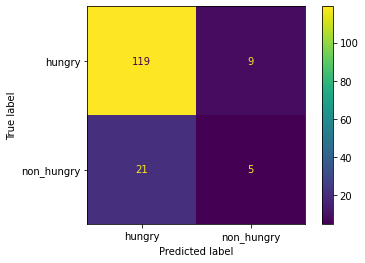

In [272]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

In [273]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=["Hungry","Non_hungry"]))

              precision    recall  f1-score   support

      Hungry       0.85      0.93      0.89       128
  Non_hungry       0.36      0.19      0.25        26

    accuracy                           0.81       154
   macro avg       0.60      0.56      0.57       154
weighted avg       0.77      0.81      0.78       154



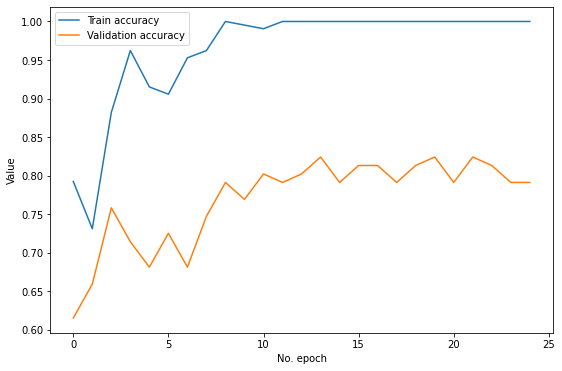

In [274]:
# Review model's progress
plt.figure(figsize=(9,6))
plt.plot(history.history['binary_accuracy'], label='Train accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()